In [1]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/Users/tayutaedomo/project/machine-learning/udemy-tensorflow-gan/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/tayutaedomo/project/machine-learning/udemy-tensorflow-gan/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/tayutaedomo/project/machine-learning/udemy-tensorflow-gan/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,

In [2]:
from scipy.io import loadmat

In [3]:
trainset = loadmat('data/train_32x32.mat')
testset = loadmat('data/test_32x32.mat')

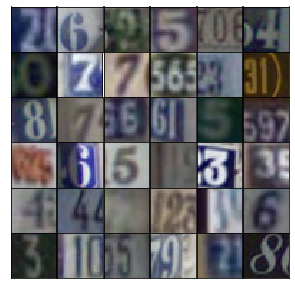

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5, 5))
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0)

In [6]:
def scale(x, feature_ranges=(-1, -1)):
    x = ((x - x.min()) / (255 - x.min()))

    min, max = feature_ranges
    x = x * (max - min) + min
    return x

In [ ]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_index = int(len(test['y']) * (1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_index], test['X'][:,:,:,split_index:]
        self.test_y, self.valid_y = test['y'][:split_index], test['y'][split_index:]
        self.train_x, self.train_y = train['X'], train['y']

        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)

        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func

        self.shuffle = shuffle

    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]

        n_batches = len(self.train_y)//batch_size

        for ii in rai